# 6-1. 프로젝트: 고양이 수염 스티커 만들기

### Step 1. 스티커 구하기

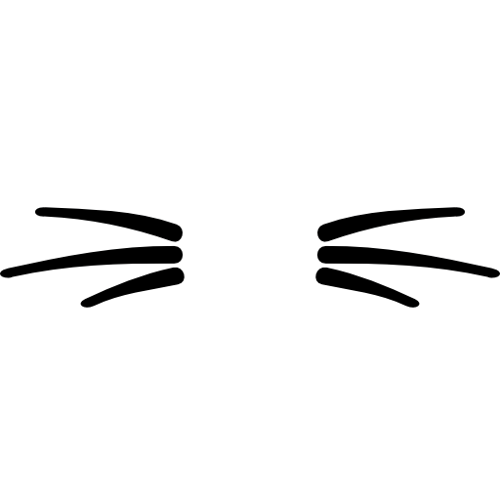

이 고양이 수염을 붙여 보겠습니다.

In [1]:
# 필요 패키지 import
import os # 환경 변수나 디렉터리, 파일 등의 OS 자원을 제어할 수 있게 해주는 모듈
import cv2 # OpenCV라이브러리 → 컴퓨터 비전 관련 프로그래밍을 쉽게 할 수 있도록 도와주는 라이브러리
import matplotlib.pyplot as plt # 다양한 데이터를 많은 방법으로 도식화 할 수 있도록 하는 라이브러리
import numpy as np # 다차원 배열을 쉽게 처리하고 효율적으로 사용할 수 있도록 하는 라이브러리
import dlib # 이미지 처리 및 기계 학습, 얼굴인식 등을 할 수 있는 c++ 로 개발된 고성능의 라이브러리 

cv2의 imshow 함수가 주피터에서 안되는 것 같아서 plt show 함수를 사용하기 위해 cv -> plt로 변환 하는 것을 함수로 생성

In [2]:
def imshow(img):
    img_bgr = img.copy()      # 출력용 이미지를 따로 보관합니다
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # bgr 이미지를 rgb 이미지로 변환
    plt.imshow(img_rgb) # 이미지를 출력하기 위해 출력할 이미지를 올려준다. (실제 출력은 하지 않음)
    plt.show() 

### Step 2. 얼굴 검출 & 랜드마크 검출 하기
 dlib을 이용해서 얼굴의 bounding box 위치와 landmark의 위치를 찾기

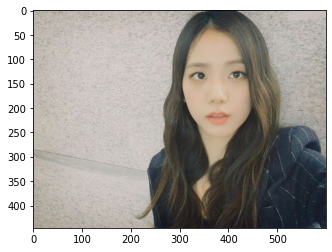

In [3]:
my_image_path = './JISU_1.png' # 본인 이미지가 있는 경로를 가지고 온다.
img = cv2.imread(my_image_path)    # OpenCV로 이미지를 불러옵니다
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # bgr 이미지를 rgb 이미지로 변환
imshow(img)

rectangles[[(283, 77) (469, 263)]]


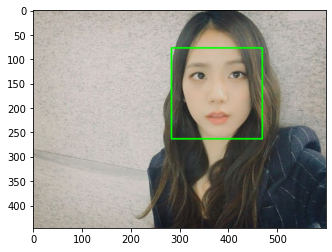

In [4]:
face_detector = dlib.get_frontal_face_detector() # face_detector 생성
dlib_rects = face_detector(img_rgb, 1) # face 
print(dlib_rects)

img_show = img.copy()
for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
    l = dlib_rect.left() # 왼쪽
    t = dlib_rect.top() # 위쪽
    r = dlib_rect.right() # 오른쪽
    b = dlib_rect.bottom() # 아래쪽

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA) # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그림
imshow(img_show)

In [5]:
list_landmarks = []
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # landmark detector 생성
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)
print(len(list_landmarks[0]))

68


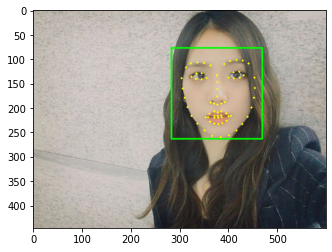

In [6]:
# 랜드마크가 잘 찍히나 확인하기 
# img_show = img.copy()
for landmark in list_landmarks:
    for point in landmark:
        cv2.circle(img_show, point, 2, (0, 255, 255), -1)
            # cv2.circle: OpenCV의 원을 그리는 함수
            # img_show 이미지 위 각각의 point에
            # 크기가 2이고 (0, 255, 255)색으로 내부가 채워진(-1) 원을 그림
            # (마지막 인수가 자연수라면 그만큼의 두께의 선으로 원이 그려짐)
imshow(img_show)

### Step 3. 스티커 적용 위치 확인하기
고양이 수염이 적용 될 위치를 landmark를 사용해서 계산

In [7]:
# 스티커 w,h, x,y 계산
x = landmark[33][0]  # 코 위치
y = landmark[33][1]  # 코 위치
w = dlib_rect.width()
h = dlib_rect.height() / 4

In [8]:
# 코 중앙을 기준으로 한번 그려보자
img_sticker = cv2.imread('./cat_sk.jpg')  
img_sticker = cv2.resize(img_sticker, (int(w),int(h)))

refined_x = int(x - w // 2)                 #  377 - (187//2) = 437-93 = 344
refined_y = int(y - img_sticker.shape[0]/2) # - h)  # 89-187 = -98

print(refined_y, y, h)
print(refined_x, x, w, w // 2)

# print(refined_y, refined_y,img_sticker.shape[0], refined_y+img_sticker.shape[0])
# print(refined_x, refined_x,img_sticker.shape[1], refined_x+img_sticker.shape[1])
img_show = img.copy()
sticker_area = img_show[int(refined_y):int(refined_y+img_sticker.shape[0]), int(refined_x):int(refined_x+img_sticker.shape[1])]

170 193 46.75
284 377 187 93


### Step 4. 스티커 적용하기
```np.where``` 를 사용해서 스티커를 적용

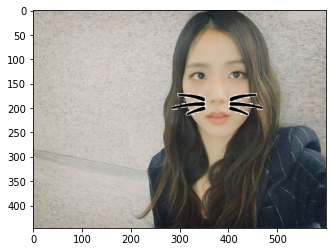

In [9]:
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x + img_sticker.shape[1]] = \
     np.where(img_sticker==255, sticker_area, img_sticker).astype(np.uint8)

imshow(img_show)

opencv 의 ```cv2.addWeighted()```등을 이용하여 스티쿼 뒤로 원본 이미지가 보이도록 알파 값 조정

### Step 5. 문제점 찾아보기

다양한 각도에서 촬영하면서 스티커를 반복해서 적용

 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 
 
 ex) 오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.
 
    - 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
    - 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
    - 실행 속도가 중요할까요?
    - 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

 ###### Q: 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
     - A: 얼굴의 fitch rol  angle 등을 계산하여 회전과 좌우 수염의 크기를 달리하여 조절해야 합니다.

 ###### Q: 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
     - A: 얼굴 크기가 너무 작으면 detecting을 못 할수 있습니다.
     얼굴을 학습 시킬때 적정크기 이하는 학습을 안했을 수 있으며, 모델이 얼굴이라 파악 못 할수도 있습니다.
     반대로 얼굴이 너무 크다면, 정해놓은 앵글의 크기보다 얼굴이 더 커지면 얼굴을 못 찾거나 엉뚱한 위치로 얼굴을 찾을 수 있기에 input의 크기를 적절히 조절하여 이용해야 합니다.
     이와같이 옆으로 누워서 촬영한 얼굴도 모델이 얼굴을 못 찾을수 있습니다.

 ###### Q: 실행 속도가 중요할까요?
     - A: 현재와 같이 하나의 사진에 스티커를 입힌다면 큰 불편함을 느끼지 못 할수있지만, 
     카메라 프리뷰에 직접 연동하거나 동영상에 스티커를 삽입할때에는 엔드유저가 불편함을 많이 느낄것으로 예상하기에,
     실행 속도는 매우 중요한 요소 중 하나라고 파악됩니다.

###### Q: 스티커앱을 만들 때 정확도가 얼마나 중요할까요?
     - A: 위 문제와 같이 엔드 유저에 입장에서 내 얼굴을 인식하지 못하거나, 잘못 인식하여 스티커의 위치가 잘못되어 나타난다면 큰 불편함을 느낄 것이기에 정확도는 중요한 요소 중 하나 입니다.

#### 다양한 조건을 가진 스티커 적용 함수 만들기
   #####  얼굴 박스와 랜드마크 그리기

In [10]:
def get_boxes_landmarks(_img, _face_detector, _landmark_predictor,):
    img_org = _img.copy()
    img_rgb = cv2.cvtColor(img_org, cv2.COLOR_BGR2RGB)
    dlib_rects = _face_detector(img_rgb, 1) # face 
    list_landmarks = []
    for dlib_rect in dlib_rects:
        points = _landmark_predictor(img_rgb, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽

        cv2.rectangle(img_org, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
        for point in landmark:
            cv2.circle(img_org, point, 2, (0, 255, 255), -1)
        
    return dlib_rects, list_landmarks, img_org

   ##### 아무런 조건 없는 스티커 적용 함수 만들기

In [11]:
def add_sticker(_img, _dlib_rects, _list_landmarks, _img_sticker):
    img_org = _img.copy()
   
    for dlib_rect, landmark in zip(_dlib_rects, _list_landmarks):
        x = landmark[30][0]  
        y = landmark[30][1] 
        w = dlib_rect.width()
        h = dlib_rect.height() / 4
        
        img_sticker_def = cv2.resize(_img_sticker, (int(w),int(h)))
        
        refined_x = int(x - w // 2)               
        refined_y = int(y - img_sticker_def.shape[0]/2) 
        
        if refined_x < 0: 
            img_sticker_def = img_sticker_def[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker_def = img_sticker_def[-refined_y:, :] 
            refined_y = 0
            
        sticker_area = img_org[refined_y:refined_y+img_sticker_def.shape[0], refined_x:refined_x+img_sticker_def.shape[1]]
        img_org[refined_y:refined_y + img_sticker_def.shape[0], refined_x:refined_x + img_sticker_def.shape[1]] = \
        np.where(img_sticker_def==255, sticker_area, img_sticker_def).astype(np.uint8)
    return img_org

In [12]:
face_detector = dlib.get_frontal_face_detector() # face_detector 생성
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path) # landmark detector 생성

###### 사진이 90도 회전된 경우
사진을 구하기 힘들어서 ```cv2.rotate```을 이용하여 회전시키겠습니다

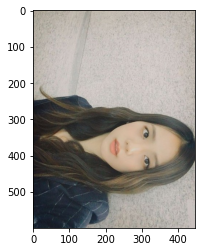

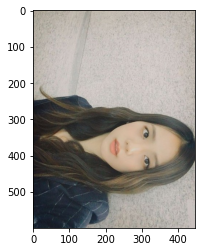

In [13]:
my_image_path = './JISU_1.png' 
img = img = cv2.imread(my_image_path) 
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './cat_sk.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker(img, dlib_rects, list_landmarks, img_sticker)
imshow(scicker_add_img)

###### 얼굴이 정면이 아닌 경우

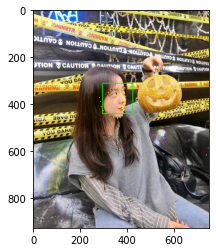

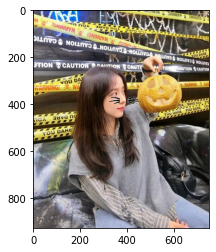

In [14]:
my_image_path = './JISU_2.jpg' 
img = img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './cat_sk.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker(img, dlib_rects, list_landmarks, img_sticker)
imshow(scicker_add_img)

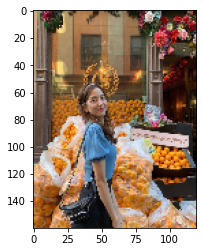

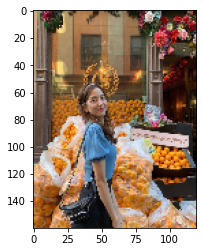

In [15]:
my_image_path = './JISU_3.jpg' 
img = cv2.imread(my_image_path) 
img = cv2.resize(img, (120, 160)) # 작은얼굴 사진을 구히지 못하여 사진크기를 줄임
dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './cat_sk.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker(img, dlib_rects, list_landmarks, img_sticker)
imshow(scicker_add_img)

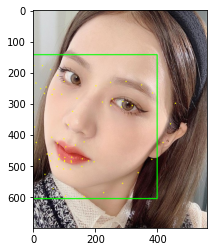

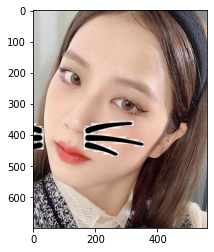

In [16]:
my_image_path = './JISU_4.jpg' 
img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './cat_sk.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker(img, dlib_rects, list_landmarks, img_sticker)
imshow(scicker_add_img)

In [17]:
import math
def get_angle(landmark):
    dy = landmark[66][1] - landmark[27][1]
    dx = landmark[66][0] - landmark[27][0]
#     dy = landmark[30][1] - landmark[27][1]
#     dx = landmark[30][0] - landmark[27][0]
    return (math.atan2(dy, dx) * (180.0 / math.pi)) - 90

In [18]:
def rotate_image(image, angle):
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR,borderValue=(255,255,255))
    return result

In [19]:
def add_sticker_whit_rotate(_img, _dlib_rects, _list_landmarks, _img_sticker):
    img_org = _img.copy()
  
    for dlib_rect, landmark in zip(_dlib_rects, _list_landmarks):
        # 36 39 중앙
        # 42 45 중앙
        # 그 중앙
        
#         x = (((landmark[36][0] + landmark[39][0]) / 2 ) + ((landmark[42][0] + landmark[45][0]) / 2 ) ) / 2
        x = (landmark[31][0] + landmark[35][0]) / 2 
        y = landmark[33][1] 
#         y = (((landmark[36][1] + landmark[39][1]) / 2 ) + ((landmark[42][1] + landmark[45][1]) / 2 ) ) / 2
        
        w = dlib_rect.width()
        h = dlib_rect.height()
        print((int(w),int(h)))
#         img_sticker_def = cv2.resize(_img_sticker, (int(w),int(h)))
        angle = get_angle(landmark) * -1
        print(angle)
        img_sticker_rotate = rotate_image(_img_sticker, angle)
        img_sticker_rotate = cv2.resize(img_sticker_rotate, (int(w),int(h)))
        imshow(img_sticker_rotate)
        w = img_sticker_rotate.shape[1]
        h = img_sticker_rotate.shape[0]
        refined_x = int(x - w // 2)               
        refined_y = int(y - img_sticker_rotate.shape[0]/2) 
        
        if refined_x < 0: 
            img_sticker_rotate = img_sticker_rotate[:, -refined_x:]
            refined_x = 0
        if refined_y < 0:
            img_sticker_rotate = img_sticker_rotate[-refined_y:, :] 
            refined_y = 0
            
        sticker_area = img_org[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
        img_org[refined_y:refined_y + img_sticker_rotate.shape[0], refined_x:refined_x + img_sticker_rotate.shape[1]] = \
        np.where(img_sticker_rotate==255, sticker_area, img_sticker_rotate).astype(np.uint8)
    return img_org

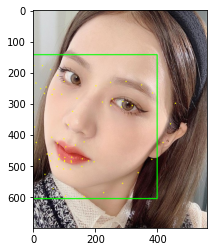

libpng warning: Incorrect sBIT chunk length


(514, 463)
-11.309932474020215


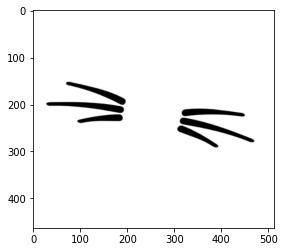

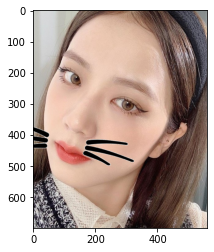

In [20]:
my_image_path = './JISU_4.jpg' 
img = cv2.imread(my_image_path) 
dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './new_cat.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker_whit_rotate(img, dlib_rects, list_landmarks, img_sticker)

imshow(scicker_add_img)

역시 dlib은 못 쓸것...

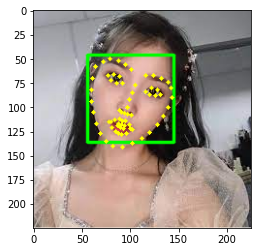

(90, 91)
-18.82471001824007


libpng warning: Incorrect sBIT chunk length


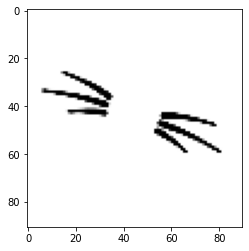

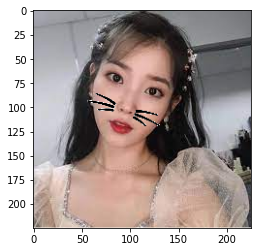

In [21]:
my_image_path = './IU_1.jpg' 
img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './new_cat.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker_whit_rotate(img, dlib_rects, list_landmarks, img_sticker)

imshow(scicker_add_img)

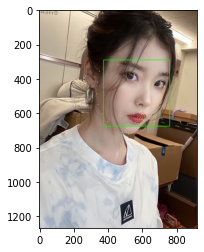

libpng warning: Incorrect sBIT chunk length


(386, 386)
-14.100118335012993


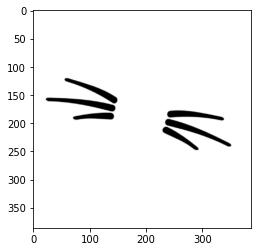

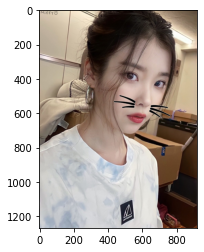

In [22]:
my_image_path = './IU_2.jpg' 
img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './new_cat.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker_whit_rotate(img, dlib_rects, list_landmarks, img_sticker)

imshow(scicker_add_img)

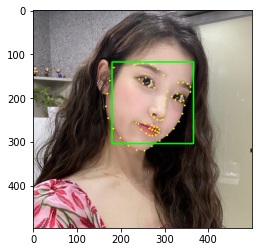

(187, 187)
-22.249023657212376


libpng warning: Incorrect sBIT chunk length


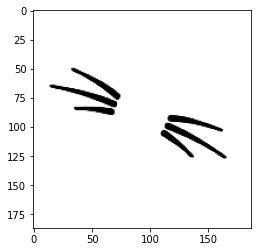

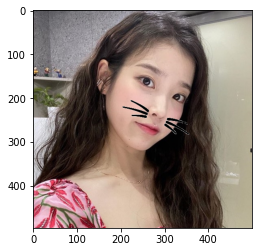

In [23]:
my_image_path = './IU_3.jpg' 
img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './new_cat.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker_whit_rotate(img, dlib_rects, list_landmarks, img_sticker)

imshow(scicker_add_img)

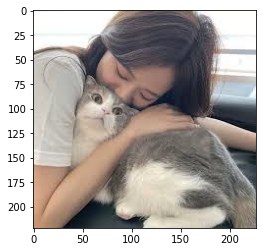

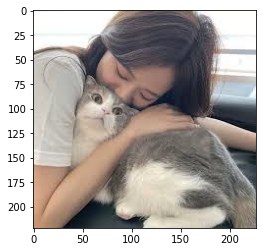

In [24]:
my_image_path = './JISU_5.jpg' 
img = cv2.imread(my_image_path) 

dlib_rects, list_landmarks, img_bos_landmark= get_boxes_landmarks(img, face_detector, landmark_predictor)
imshow(img_bos_landmark)

my_sticker_path = './cat_sk.jpg' 
img_sticker = cv2.imread(my_sticker_path) 

scicker_add_img = add_sticker(img, dlib_rects, list_landmarks, img_sticker)
imshow(scicker_add_img)